In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import SVD

# Данные

In [2]:
data = pd.read_csv('Matrix_train.csv', index_col=0)
X_train = data.to_numpy()
display(data.replace(0, np.nan))
print(f'{data.shape[1]} фильмов \n{data.shape[0]} зрителей\n')
print(f'Всего оценок: {data.shape[1] * data.shape[0]}')
print(f'Из них: {len(np.where(X_train<0.5)[1])} пропусков')

,607,798,1798,1905,2452,2782,2862,3106,4306,6196,...,14670,14691,14780,15107,15124,16384,16765,16954,17088,17560
userId,,,,,,,,,,,,,,,,,,,,,
3321,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,NaN,4.0,...,4.0,5.0,4.0,4.0,4.0,NaN,4.0,5.0,4.0,4.0
3998,5.0,4.0,5.0,NaN,5.0,5.0,5.0,5.0,5.0,NaN,...,5.0,5.0,5.0,5.0,5.0,4.0,NaN,NaN,5.0,5.0
10268,4.0,3.0,4.0,3.0,4.0,4.0,5.0,3.0,3.0,5.0,...,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
10374,4.0,4.0,3.0,NaN,5.0,5.0,5.0,5.0,5.0,5.0,...,4.0,5.0,5.0,4.0,NaN,5.0,4.0,5.0,5.0,3.0
11043,5.0,4.0,5.0,5.0,4.0,5.0,NaN,NaN,4.0,4.0,...,4.0,4.0,4.0,NaN,5.0,5.0,5.0,NaN,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2626336,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,...,4.0,5.0,3.0,4.0,NaN,5.0,4.0,4.0,3.0,4.0
2640278,3.0,NaN,4.0,5.0,NaN,5.0,5.0,2.0,5.0,4.0,...,4.0,5.0,NaN,NaN,4.0,4.0,5.0,5.0,5.0,4.0
2640550,NaN,3.0,3.0,5.0,4.0,3.0,3.0,NaN,5.0,3.0,...,3.0,4.0,4.0,3.0,4.0,3.0,4.0,NaN,3.0,3.0


30 фильмов 
553 зрителей

Всего оценок: 16590
Из них: 1608 пропусков


In [8]:
movies_titles = pd.read_csv('movie_names.csv', index_col=0)
display(movies_titles.head(10))

,year,title
movieId,,
607,1994.0,Speed
798,1975.0,Jaws
1798,1987.0,Lethal Weapon
1905,2003.0,Pirates of the Caribbean: The Curse of the Bla...
2452,2001.0,Lord of the Rings: The Fellowship of the Ring
2782,1995.0,Braveheart
2862,1991.0,The Silence of the Lambs
3106,1990.0,Ghost
4306,1999.0,The Sixth Sense


# Постановка задачи

Начнем с исходных данных и постановки задачи. У нас есть таблица с оценками фильмов. Индексы строк это id людей, а индексы столбцов - id фильмов. Все числа натуральные.

In [ ]:
print(X_train)

Задача состоит в том, чтобы аппроксимировать значения ячеек, где в начальной таблице стоят нули. Иными словами, мы хотим предсказать, какие фильмы можно посоветовать посмотреть пользователям из исходной таблицы.


# Решение

Решение будем искать в виде $X_k = P \cdot Q^T$, 
где матрица
$$P = \begin{pmatrix} \dots \; p_0 \; \dots \\ \dots \; p_1 \; \dots  \\ \vdots \\  \dots p_{n_{users}} \dots \end{pmatrix}$$

состоит из векторов $p_u = (p_u^1, p_u^2, p_u^3, ..., p_u^k)^T$, которые отвечают за предпочтения пользователя.

Они называются _скрытыми признаками_. Каждый пользователь описывается $k$ признаками.

Аналогично для фильмов матрица
$$Q = \begin{pmatrix} \dots \; q_0 \; \dots \\ \dots \; q_1 \; \dots  \\ \vdots \\  \dots q_{n_{items}} \dots \end{pmatrix}$$

состоит из веторов $q_i^T = (q_i^1, q_i^2, q_i^3, ..., q_i^k)^T$, которые являются некоторыми описаниями фильмов.

Таким образом, каждая оценка $\hat r_{ui}$ является скалярным произведением векторов $\hat r_{ui} = (p_u, q_i)$

Чтобы найти неизвестные оценки, мы минимизируем следующую регуляризованную функцию потерь:


$$ L = \sum_{u, i \in observed\;ratings} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(||q_i||^2 + ||p_u||^2\right)$$


Минимизация выполняется очень простым стохастическим градиентным спуском:

$$p_u \leftarrow p_u + \gamma ((r_{ui} - \hat{r}_{ui}) \cdot q_i - \lambda p_u)\\
q_i \leftarrow q_i + \gamma ((r_{ui} - \hat{r}_{ui}) \cdot p_u - \lambda q_i)$$

In [4]:
Netflix = SVD.SVD()

Перед обучением модели нам требуется определить размерность $k$ скрытого пространства (__latent space__)

Для этого организуем валидационную выборку: ~1500 значений.

In [15]:
Netflix.sample(X_train)

Обучаем модели с разным количеством латентных признаков $k$, предсказываем оценки на отложенной (валидационной) выборке, оцениваем предсказания - выбираем лучшую модель

In [16]:
N = 10
RMSE = np.zeros(N)
ERROR = np.zeros(N)
accuracy = np.zeros(N)
K = np.arange(1,N+1)
for k in K:
    Netflix.fit(X = Netflix.X_val, k = k, U=Netflix.U_val, I=Netflix.I_val, gamma = 0.01, l = 0.03, n_epochs=600)
    print('k = ', k)
    Netflix.estimate(Z_r = Netflix.Zeros_validation_U, Z_c = Netflix.Zeros_validation_I, plot=False)
    ERROR[k-1] = Netflix.ERROR
    RMSE[k-1] = Netflix.RMSE
    accuracy[k-1] = 0.4 * Netflix.accuracy[5] + 0.4 * Netflix.accuracy[2] + 0.2 * Netflix.accuracy[4]
    print('Absolute Error (на последних 10 итерациях) = ', np.round(Netflix.error[-10:]))
    print(Netflix.accuracy)
    print('-----------------------------')

k =  1
Все уникальные значения предсказания:  [2. 3. 4. 5.]
Суммарная ошибка предсказания:  973.0
max_absolute_error:  4.0
RMSE:  0.8652552609875693
Absolute Error (на последних 10 итерациях) =  [8624. 8624. 8624. 8624. 8624. 8624. 8624. 8624. 8624. 8624.]
{1: 0.0, 2: 0.02, 3: 0.21, 4: 0.83, 5: 0.15}
-----------------------------
k =  2
Все уникальные значения предсказания:  [2. 3. 4. 5.]
Суммарная ошибка предсказания:  833.0
max_absolute_error:  3.0
RMSE:  0.8119934318289362
Absolute Error (на последних 10 итерациях) =  [7598. 7598. 7598. 7598. 7598. 7598. 7598. 7598. 7598. 7598.]
{1: 0.0, 2: 0.02, 3: 0.25, 4: 0.75, 5: 0.45}
-----------------------------
k =  3
Все уникальные значения предсказания:  [1. 2. 3. 4. 5.]
Суммарная ошибка предсказания:  806.0
max_absolute_error:  3.0
RMSE:  0.8008328997570799
Absolute Error (на последних 10 итерациях) =  [7249. 7249. 7249. 7249. 7249. 7250. 7249. 7249. 7250. 7249.]
{1: 0.0, 2: 0.1, 3: 0.31, 4: 0.73, 5: 0.47}
-----------------------------
k 

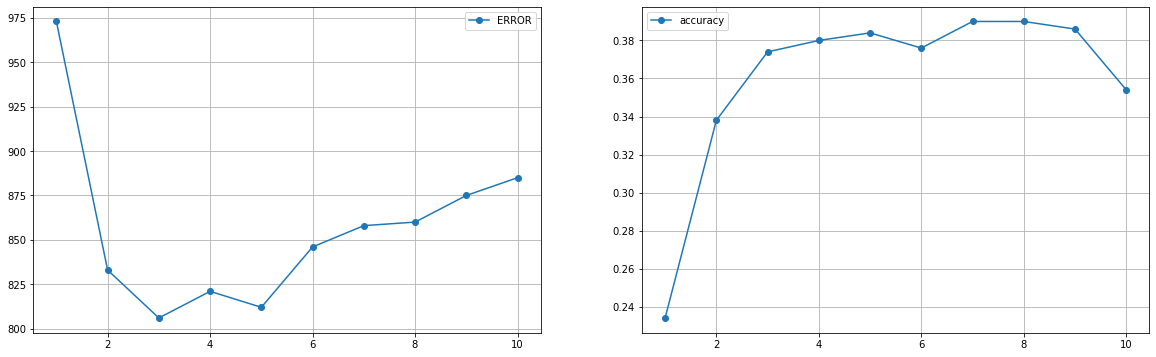

In [18]:
estimators = [ERROR, accuracy]
labels = ['ERROR', 'accuracy']
fig, ax = plt.subplots(1, len(estimators), figsize=(20, 6))
for i in range(len(estimators)):
    ax[i].plot(K, estimators[i], '-o',label=labels[i])
    ax[i].grid()
    ax[i].legend()

По итогам двух критериев возбмем __k = 5__

# Финальное предсказание

Все уникальные значения предсказания:  [1. 2. 3. 4. 5. 6.]
Суммарная ошибка предсказания:  840.0
max_absolute_error:  3.0
RMSE:  0.793317864308403
{1: 0.06, 2: 0.17, 3: 0.32, 4: 0.73, 5: 0.48}


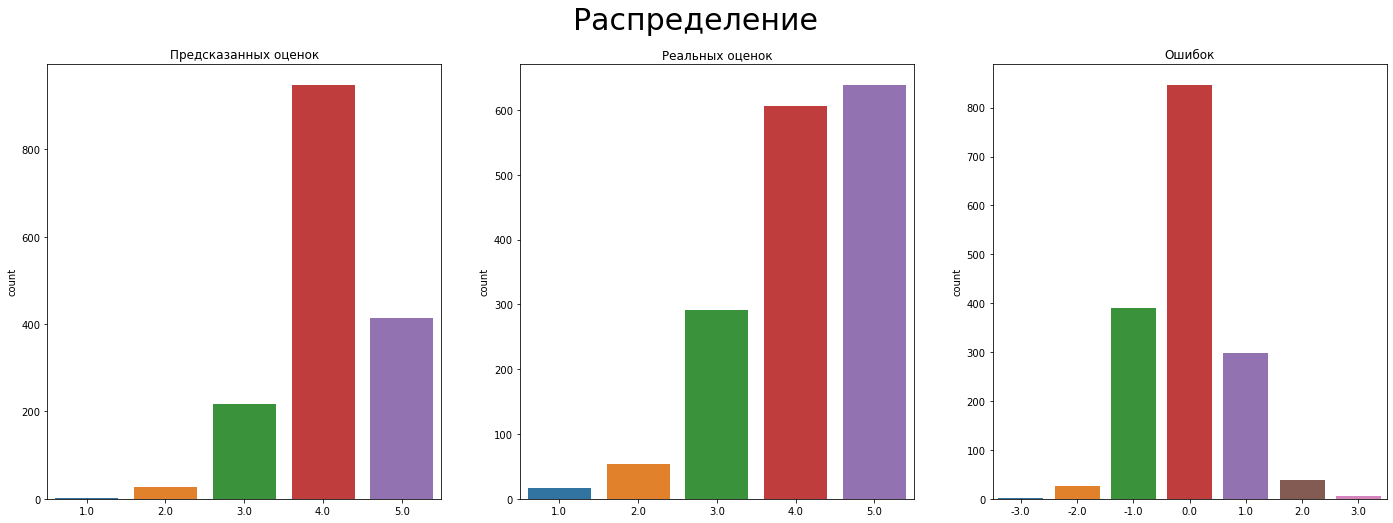

In [20]:
U, I = np.where(X_train > 0.5)
Netflix.fit(X=X_train, U=U, I=I, verbose=False, n_epochs=600, k=5, gamma=0.01, l=0.03)
Z_r, Z_c = np.where(X_train < 0.5)
Netflix.estimate(Z_r=Z_r, Z_c=Z_c, val=False)
print(Netflix.accuracy)

# Скрытые факторы

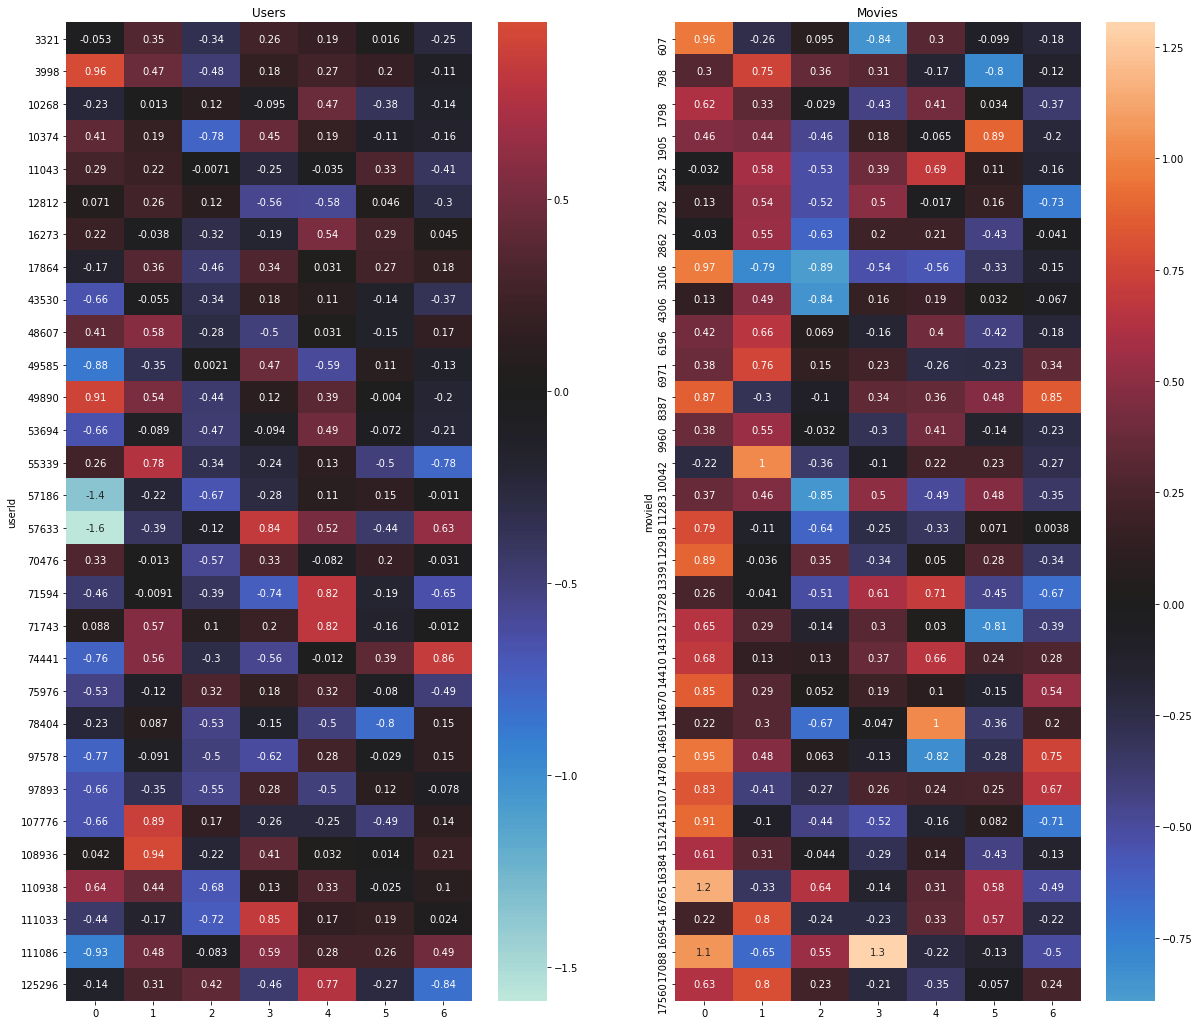

In [22]:
Netflix.factors(data)

In [23]:
movies = pd.DataFrame(data=Netflix.q)
cosine_sim = cosine_similarity(movies, movies)
indices = pd.Series(movies.index, index=movies_titles.title).drop_duplicates()

In [26]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:8]
    movie_indices = [i[0] for i in sim_scores]
    return movies_titles['title'].iloc[movie_indices].values

# Косинусное сходство фильмов в скрытом пространстве (Latent space)

In [27]:
for title in movies_titles['title']:
    print(title)
    print(get_recommendations(title))
    print('--------------------------------------\n')
# Ближайшие соседи (по данной метрике) для каждого из фильмов

Speed
['True Lies' 'Lethal Weapon' 'Independence Day' 'The Fugitive' 'Face/Off'
 'Ghost' 'Men in Black']
--------------------------------------

Jaws
["Ferris Bueller's Day Off" 'Jurassic Park' 'The Terminator'
 'Ghostbusters' 'The Fugitive' 'Beetlejuice' 'The Silence of the Lambs']
--------------------------------------

Lethal Weapon
['Die Hard' 'The Fugitive' 'Speed' 'The Terminator' 'True Lies'
 'Independence Day' 'Indiana Jones and the Last Crusade']
--------------------------------------

Pirates of the Caribbean: The Curse of the Black Pearl
['Forrest Gump' 'Indiana Jones and the Last Crusade' 'Braveheart'
 'The Sixth Sense' 'Raiders of the Lost Ark' 'Men in Black'
 'Lord of the Rings: The Fellowship of the Ring']
--------------------------------------

Lord of the Rings: The Fellowship of the Ring
['The Sixth Sense' 'The Matrix' 'The Silence of the Lambs'
 'Raiders of the Lost Ark' 'Braveheart' 'Gladiator'
 'Indiana Jones and the Last Crusade']
---------------------------------